# MNIST - Digit Recognizer
Reference: [Kaggle Competition](https://www.kaggle.com/c/digit-recognizer)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [23]:
train_df = pd.read_csv('mnist/train.csv')
test_df = pd.read_csv('mnist/test.csv')

print(train_df.shape)
print(test_df.shape)

(42000, 785)
(28000, 784)


## Data Visualization

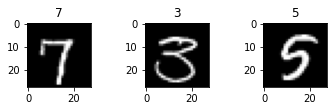

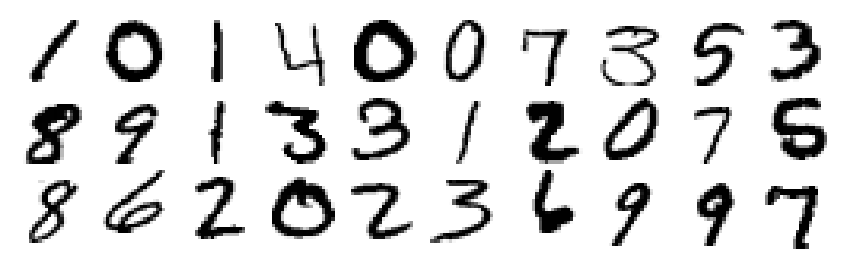

In [24]:
x_data_train = (train_df.iloc[:,1:].values).astype('float32') # all pixel values
t_data_train = train_df.iloc[:,0].values.astype('int32') # labels
x_data_test = test_df.values.astype('float32')

#Convert train datset to (num_images, img_rows, img_cols) format 
x_data_train = x_data_train.reshape(x_data_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_data_train[i], cmap=plt.get_cmap('gray'))
    plt.title(t_data_train[i]);
plt.show()
    
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(x_data_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Data Preprocessing
### 결측치 확인

In [25]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


### Data Split

In [26]:
# train data set
x_data_train = train_df.drop(labels=['label'], axis=1)
t_data_train = train_df['label']

x_train, x_test, t_train, t_test = \
train_test_split(x_data_train, t_data_train, test_size=0.3, random_state=0)

print(x_train.shape)
print(x_test.shape)

(29400, 784)
(12600, 784)


### 정규화

In [27]:
scaler_x = MinMaxScaler()

scaler_x.fit(x_train)
x_train_norm = scaler_x.transform(x_train)

scaler_x.fit(x_test)
x_test_norm = scaler_x.transform(x_test)

### One-hot Encoding

In [28]:
sess = tf.Session()
t_train_onehot = sess.run(tf.one_hot(t_train, depth=10))
t_test_onehot = sess.run(tf.one_hot(t_test, depth=10))

## Softmax Regression

### Tensorflow Graph

In [29]:
# X, T
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# W, b
W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

### Batch Learning

In [30]:
# parameter
num_of_epoch = 1000
batch_size = 100

def run_train(sess, train_x, train_t):
    print('=====START LEARNING=====')
    
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    # 반복학습
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size: (i+1)*batch_size]
            batch_t = train_t[i*batch_size: (i+1)*batch_size]
            
            _, loss_val = sess.run([train, loss], feed_dict={X: batch_x, T: batch_t})
        
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    print('=====FINISH LEARNING=====')

## Accuracy

In [31]:
predict = tf.argmax(H, axis=1)
correct = tf.equal(predict, tf.argmax(T, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

## K-fold Cross Validation

In [33]:
cv = 5
results = []

kf = KFold(n_splits=cv, shuffle=True)

for training_idx, validation_idx in kf.split(x_train_norm):
    training_x = x_train_norm[training_idx]
    training_t = t_train_onehot[training_idx]
    
    validation_x = x_train_norm[validation_idx]
    validation_t = t_train_onehot[validation_idx]
    
    # learning
    run_train(sess, training_x, training_t)
    
    # validation
    results.append(sess.run(accuracy, feed_dict={X: validation_x, T: validation_t}))
    
final_acc = np.mean(results)
print('각 Fold의 Accuracy: {}'.format(results))
print('K-fold Validation을 통한 우리 모델의 Accuracy: {}'.format(final_acc))

=====START LEARNING=====
Loss: 0.7962501645088196
Loss: 0.16594097018241882
Loss: 0.16169506311416626
Loss: 0.1558171510696411
Loss: 0.14902278780937195
Loss: 0.14278212189674377
Loss: 0.1374281644821167
Loss: 0.13294875621795654
Loss: 0.12923099100589752
Loss: 0.1261277198791504
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.7045877575874329
Loss: 0.12226524949073792
Loss: 0.10261969268321991
Loss: 0.09378039091825485
Loss: 0.08811765909194946
Loss: 0.08403808623552322
Loss: 0.08096484839916229
Loss: 0.07858357578516006
Loss: 0.07669753581285477
Loss: 0.07517228275537491
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.8188373446464539
Loss: 0.11926908791065216
Loss: 0.10503313690423965
Loss: 0.09597429633140564
Loss: 0.08919818699359894
Loss: 0.0838649570941925
Loss: 0.07950261235237122
Loss: 0.07586028426885605
Loss: 0.07280713319778442
Loss: 0.07025153934955597
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.9098227024078369
Loss: 0.1695750206708908

## Testing

In [34]:
run_train(sess, training_x, training_t)
final_accuracy = sess.run(accuracy, feed_dict={X: x_test_norm, T: t_test_onehot})
print('Final Accuracy: {}'.format(final_accuracy))

=====START LEARNING=====
Loss: 1.0371798276901245
Loss: 0.19797877967357635
Loss: 0.17341214418411255
Loss: 0.16102050244808197
Loss: 0.15174967050552368
Loss: 0.1442544013261795
Loss: 0.13801097869873047
Loss: 0.13272246718406677
Loss: 0.1281735599040985
Loss: 0.12420977652072906
=====FINISH LEARNING=====
Final Accuracy: 0.9046825170516968


## Evaluation

              precision    recall  f1-score   support

       num 0       0.95      0.94      0.95      1242
       num 1       0.96      0.96      0.96      1429
       num 2       0.90      0.88      0.89      1276
       num 3       0.87      0.89      0.88      1298
       num 4       0.92      0.90      0.91      1236
       num 5       0.86      0.85      0.85      1119
       num 6       0.92      0.94      0.93      1243
       num 7       0.94      0.92      0.93      1334
       num 8       0.85      0.87      0.86      1204
       num 9       0.86      0.89      0.87      1219

    accuracy                           0.90     12600
   macro avg       0.90      0.90      0.90     12600
weighted avg       0.91      0.90      0.90     12600

[[1173    0   14    6    2   15   19    2    9    2]
 [   0 1375    9   10    1    3    6    0   21    4]
 [  13   18 1118   42   13   10   18   14   20   10]
 [   5    3   25 1156    1   47    4    9   30   18]
 [   5   11    9    2 1109   

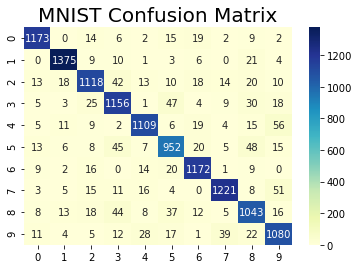

In [35]:
# Precision, Recall, F1, Accuracy
names = ['num 0', 'num 1', 'num 2', 'num 3', 'num 4', 'num 5', 'num 6', 'num 7', 'num 8', 'num 9']
report = classification_report(t_test, sess.run(predict, feed_dict={X: x_test_norm}),
                     target_names=names)
print(report)

# Confusion Matrix
confusion_mtrx = confusion_matrix(t_test, sess.run(predict, feed_dict={X: x_test_norm}))
print(confusion_mtrx) 

sns.heatmap(confusion_mtrx, annot=True, fmt='d', cmap='YlGnBu')
plt.title('MNIST Confusion Matrix', fontsize=20)
plt.show()

## Prediction

In [57]:
# normalization
test_norm = scaler_x.transform(test_df)

# prediction
result = sess.run(predict, feed_dict={X: test_norm})

# 결합
new_df = pd.read_csv('mnist/test.csv')
new_df['Label'] = result
display(new_df)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Test Data Visualization

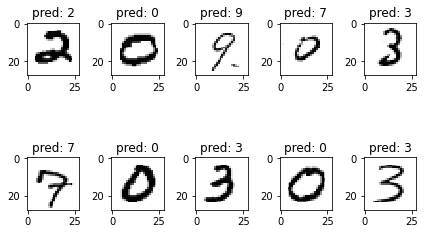

In [58]:
img_data = new_df.drop('Label', axis=1, inplace=False).values # 픽셀 데이터 (2차원 ndarray)

fig = plt.figure() 
fig_arr = [] # 10개의 subplot을 생성해서 그 각각의 subplot을 리스트에 저장

for n in range(10):
    fig_arr.append(fig.add_subplot(2,5, n+1)) # 2행 5열, 몇번째(1번째 부터 시작)
    pred_val = new_df.loc[n, 'Label']
    
    fig_arr[n].set_title('pred: {}'.format(pred_val))
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='Greys', interpolation='nearest') 
    
plt.tight_layout()
plt.show()

## Submission

In [65]:
for i in range(len(new_df)):
    new_df.loc[i, 'ImageId'] = i + 1
display(new_df)

submission = pd.DataFrame({
    'ImageId': new_df['ImageId'],
    'Label': new_df['Label']
})
display(submission)

submission.to_csv('mnist/mnist_submission.csv', index=False)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,Label,ImageId
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,27996
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,27997
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,27998
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,27999


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
